# Importing Libraries

In [1]:
import sys
sys.path.append('..')
from scripts.model import Model
from scripts.processor import Processor
from src.load import load_csv
from src.plot import Plot
import warnings
warnings.filterwarnings('ignore')
model = Model()
processor = Processor()
ploter = Plot()

## Loading Clean Data

In [2]:
PATH = '../data/clean_ML_rating.csv'
df = load_csv(PATH)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.head(5)

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,Month
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,2015-03
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,2015-05
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,2015-07
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,2015-05
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,2015-07


### Convert dates if any

In [3]:
date_cols = ['TransactionMonth','RegistrationYear', 'Month']  
if date_cols:
    df = processor.convert_dates(df, date_cols)

## Encode categorical variables

In [4]:
columns_label = ['Gender']
columns_onehot = ['Province', 'VehicleType','make']

df = processor.encoder(df, columns_label=columns_label, columns_onehot=columns_onehot)
df.filter(regex="Province|VehicleType|make").head(5)



,Province_Eastern Cape,Province_Free State,Province_Gauteng,Province_KwaZulu-Natal,Province_Limpopo,Province_Mpumalanga,Province_North West,Province_Northern Cape,Province_Western Cape,VehicleType_Bus,...,make_RENAULT,make_SAIC,make_SCANIA,make_SUZUKI,make_TATA,make_TOYOTA,make_TOYOTA,make_Unknown,make_VOLKSWAGEN,make_VOLVO
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scale numeric columns

In [5]:
columns_scaler = ['TotalPremium', 'SumInsured', 'CalculatedPremiumPerTerm']
df = processor.scaler('standardScaler', df, columns_scaler)

## Split features and target

In [6]:
df_claims = df[df['TotalClaims'] > 0]
X = df_claims.drop(['TotalClaims'], axis=1)
y = df_claims['TotalClaims']
X_train, X_test, y_train, y_test = model.split_data(X, y, test_size=0.2)

## Clean X_train and X_test to remove strings / whitespace


In [7]:
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

# Ensure all numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)

## Train all models

In [8]:
model.train_model(X_train, y_train)


In [9]:
models_list = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
models_obj = [model.lr_model, model.dt_model, model.rfr_model, model.xgb_model]

mae_scores, mse_scores, r2_scores = [], [], []

for m in models_obj:
    mae, mse, r2, _ = model.evaluate_model(m, X_test, y_test)
    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Print results
for i, name in enumerate(models_list):
    print(f"{name} → MAE: {mae_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}, R2: {r2_scores[i]:.4f}")


Linear Regression → MAE: 26356.7983, MSE: 7668154451.7000, R2: -3.7680
Decision Tree → MAE: 22049.6809, MSE: 2391444994.9537, R2: -0.4870
Random Forest → MAE: 16785.5255, MSE: 1318718443.5509, R2: 0.1800
XGBoost → MAE: 17840.2683, MSE: 1365087734.4460, R2: 0.1512


In [10]:
for i, model_name in enumerate(models_list):    
    print(f"Evaluation results for {model_name}:")
    print(f" - Mean Absolute Error (MAE): {mae_scores[i]}")
    print(f" - Mean Squared Error (MSE): {mse_scores[i]}")
    print(f" - R-squared (R2) Score: {r2_scores[i]}")
    print("\n")


Evaluation results for Linear Regression:
 - Mean Absolute Error (MAE): 26356.79833607309
 - Mean Squared Error (MSE): 7668154451.700046
 - R-squared (R2) Score: -3.768017434606345


Evaluation results for Decision Tree:
 - Mean Absolute Error (MAE): 22049.68094101742
 - Mean Squared Error (MSE): 2391444994.9537287
 - R-squared (R2) Score: -0.4869877102323512


Evaluation results for Random Forest:
 - Mean Absolute Error (MAE): 16785.525521517953
 - Mean Squared Error (MSE): 1318718443.5509205
 - R-squared (R2) Score: 0.18002792330379547


Evaluation results for XGBoost:
 - Mean Absolute Error (MAE): 17840.268292775407
 - Mean Squared Error (MSE): 1365087734.4459622
 - R-squared (R2) Score: 0.1511957461729767




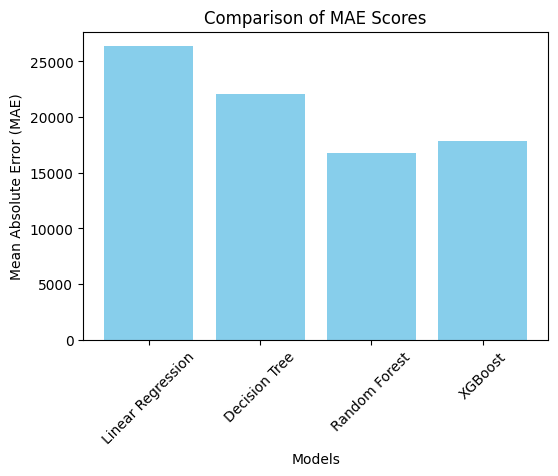

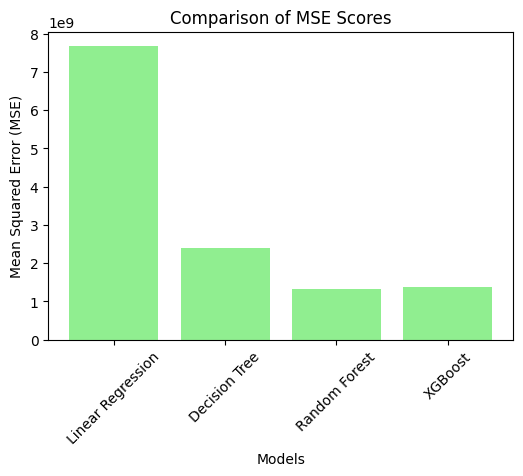

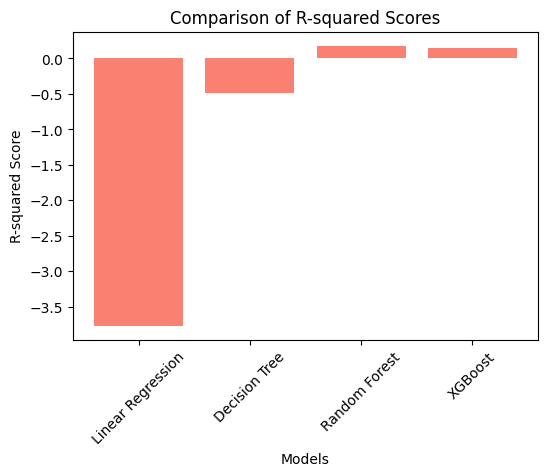

In [11]:
ploter.plot_metrics(models=models_list, mae_scores=mae_scores, mse_scores=mse_scores, r2_scores=r2_scores)

### DECISION TREE VISUALIZATION

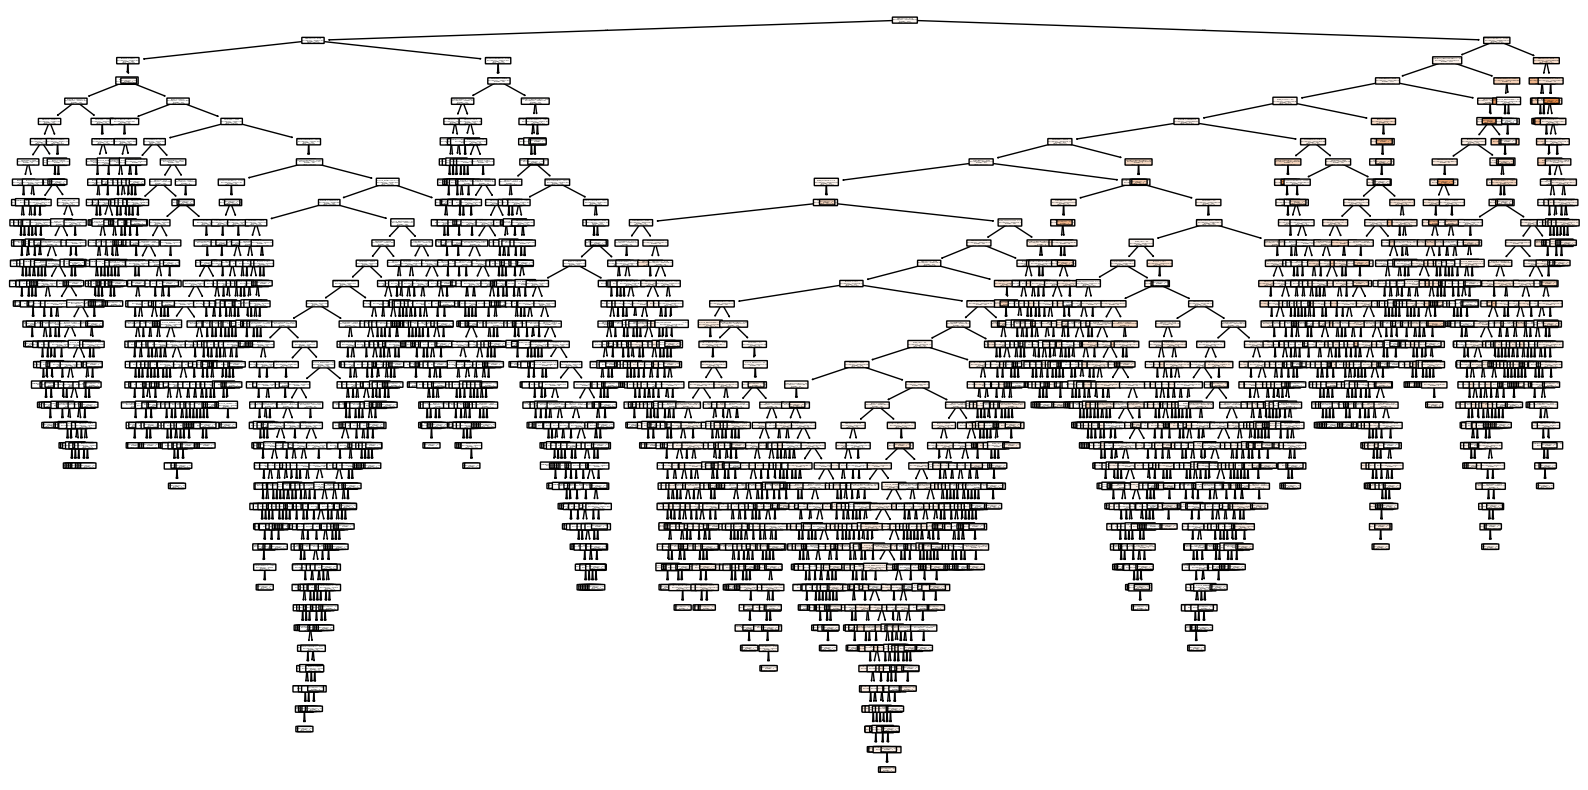

In [15]:
ploter.tree_plot(model.dt_model, X_train.columns)

### Compares which features matter most across different models.

<Figure size 1000x600 with 0 Axes>

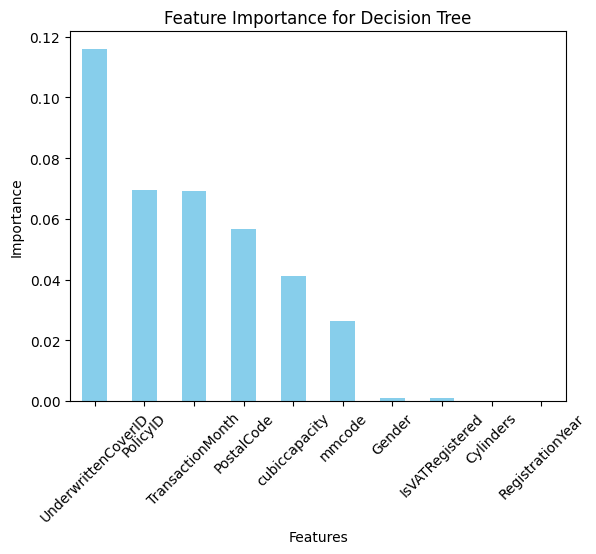

<Figure size 1000x600 with 0 Axes>

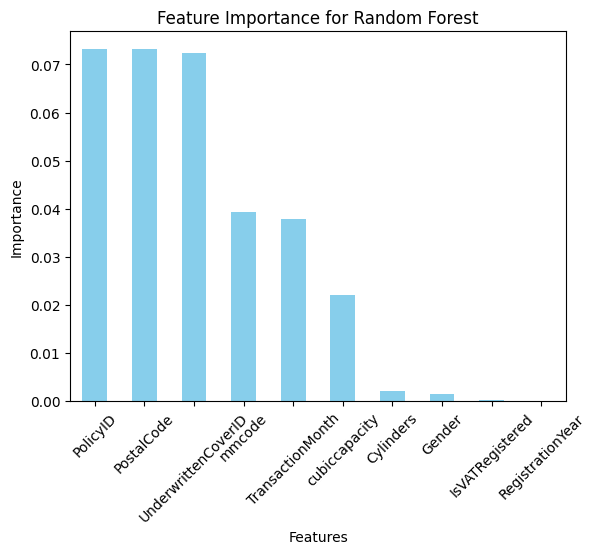

<Figure size 1000x600 with 0 Axes>

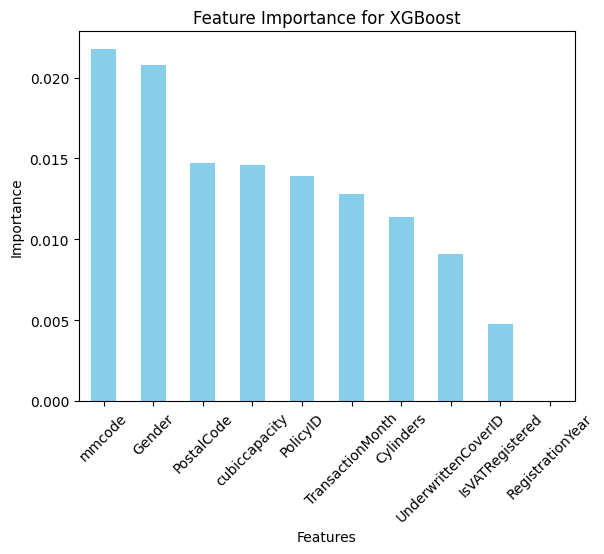

In [13]:
ploter.plot_feature_importance(model.dt_model, X_train.columns[:10], "Decision Tree")
ploter.plot_feature_importance(model.rfr_model, X_train.columns[:10], "Random Forest")
ploter.plot_feature_importance(model.xgb_model, X_train.columns[:10], "XGBoost")